# Sistemas de Múltiplos Classificadores

## 1)

Selecione cinco bases de dados públicas que contenham características diferentes e, para cada base, calcule o Oracle no conjunto de teste para:
* Bagging
* Adaboost 
* Random Subspace (50%)
* Random Oracles

variando o número de classificadores-base {10, 20, …, 100}. 

Use o Perceptron como classificador-base e divida os fold usando o 5-fold cross-validation. 

Analise os resultados. 

### Dados

1. 

2. 

3. 

4. 

5. 

In [3]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier # servirá para o Bagging e para o Random Subspace
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaseEnsemble
from rlo import RLO

import oracle

In [4]:
import warnings
# warnings.filterwarnings(action='once')
warnings.filterwarnings(action='ignore')

In [5]:
# seed
np.random.seed(111)

#### Implementação do RLO 

In [6]:
class RLO(BaseEnsemble):
    
    def __init__(self,
                 base_estimator=None,
                 n_estimators=10,
                 E = None,
                 H = None,
                ):
        super().__init__(
            base_estimator=base_estimator,
            n_estimators=n_estimators)
        
            
    def fit(self, X, y):
        N = X.shape[0]
        self.E = {f'D_{i}':{'left:':None, 'right':None} for i in range(self.n_estimators)}
        self.H = {f'H_{i}':None for i in range(self.n_estimators)}
        
        for i in range(self.n_estimators):     
            
            while True:
                try:
                    rp = np.random.choice(N, 2)
                    A, B = X[rp[0], :], X[rp[1], :]
                    self.H[f'H_{i}'] = np.hstack((A - B, (B@B.T - A@A.T)/2))
                    left = np.hstack((X, np.ones((N, 1)))) @ self.H[f'H_{i}'].T > 0
                    classificador_left = self.base_estimator
                    classificador_right = self.base_estimator
                    self.E[f'D_{i}']['left'] = classificador_left.fit(X[left, :], y[left])
                    self.E[f'D_{i}']['right'] = classificador_right.fit(X[~left, :], y[~left])
                    
                    break
                except:
                    continue
                break
                

        return self.E, self.H
#         return (E, H)

    def predict(self, X, y):

        L = len(self.E)
        ens = np.zeros((X.shape[0], L))

        for i in range(L):
            left = np.hstack((X, np.ones((X.shape[0], 1)))) @ self.H[f'H_{i}'].T > 0
            ens[left, i] = self.E[f'D_{i}']['left'].predict(X[left, :])
            ens[~left, i] = self.E[f'D_{i}']['right'].predict(X[~left, :])

        a1 = stats.mode(ens.T)[0]
        e = np.mean(a1 != y)

        return (ens, a1, e)
    
    def Oracle_predict(self, X, y):
        predictions, _, _ = self.predict(X, y)
        pred_oracle = np.any((predictions == y.reshape(-1,1)), axis=1)
        return pred_oracle
    
    def Oracle_score(self, X, y):
        pred_oracle = self.Oracle_predict(X, y)
        acc_oracle = pred_oracle.sum() / pred_oracle.shape[0]
        return acc_oracle

In [7]:
# ## Implementação do Random Linear Oracle (RLO) baseado no livro de Kuncheva



# def rlo_train(X, y, L, modelo):
#     N = X.shape[0]
#     E = {f'D_{i}':{'left:':None, 'right':None} for i in range(L)}
#     H = {f'H_{i}':None for i in range(L)}
    
#     for i in range(L):
#         rp = np.random.choice(N, 2)
#         A, B = X[rp[0], :], X[rp[1], :]
#         H[f'H_{i}'] = np.hstack((A - B, (B@B.T - A@A.T)/2))
#         left = np.hstack((X, np.ones((N, 1)))) @ H[f'H_{i}'].T > 0
#         classificador_left = modelo
#         classificador_right = modelo
#         E[f'D_{i}']['left'] = classificador_left.fit(X[left, :], y[left])
#         E[f'D_{i}']['right'] = classificador_right.fit(X[~left, :], y[~left])

#     return (E, H)

# def rlo_classificar(E, H, X, y):
    
#     L = len(E)
#     ens = np.zeros((X.shape[0], L))
    
#     for i in range(L):
#         left = np.hstack((X, np.ones((X.shape[0], 1)))) @ H[f'H_{i}'].T > 0
#         ens[left, i] = E[f'D_{i}']['left'].predict(X[left, :])
#         ens[~left, i] = E[f'D_{i}']['right'].predict(X[~left, :])
    
#     a1 = stats.mode(ens.T)[0]
#     e = np.mean(a1 != y)
    
#     return (a1, e)
    

In [8]:
# número de classificadores base
n_classificadores_base = np.arange(10, 110, 10)
print(n_classificadores_base)

[ 10  20  30  40  50  60  70  80  90 100]


In [9]:
## Base de dados para teste
data = load_breast_cancer()
X = data.data
y = data.target
# split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Scale the variables to have 0 mean and unit variance
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)


# # Split the data into training and DSEL for DS techniques
# X_train, X_dsel, y_train, y_dsel = train_test_split(X_train, y_train, test_size=0.5)

#### Testando o RLO

In [10]:
cls_base = Perceptron(max_iter=100)
rlo = RLO(base_estimator=cls_base, n_estimators=3)

# treinar
rlo.fit(X_train, y_train)

# testar 
predictions, pred_ens, erro = rlo.predict(X_test, y_test)

In [11]:
erro_rlo = np.mean(pred_ens == y_test)
print(erro_rlo)

0.9627659574468085


In [12]:
# Oracle
# pred_oracle = np.any((predictions == y_dsel.reshape(-1,1)), axis=1)
# acc_oracle = pred_oracle.sum()/pred_oracle.shape[0]
# print(f'acc Oracle: {acc_oracle}')
pred_oracle = rlo.Oracle_predict(X_test, y_test)
acc_oracle = rlo.Oracle_score(X_test, y_test)

In [13]:
print(f'Oracle Accuracy: {acc_oracle}')

Oracle Accuracy: 0.9627659574468085


#### função que faz a Validação cruzada 5fold com o RLO
#### função avalia_L_modelos para o RLO 

In [14]:
# Criando os 5 folds e salvando em dicionário
def cria_folds(X, y, n=5):
    kf = StratifiedKFold(n_splits=n)
    kfolds = dict()
    i = 1
    for train_index, test_index in kf.split(X, y):
        kfolds[f'fold{i}'] = (train_index, test_index)
        i += 1
    return kfolds

In [15]:
# criando os 5-folds
kfolds = cria_folds(X_train,y_train,n=5)

In [16]:
## função cv RLO
def cv_RLO(kfolds, RLO, X, y):
    '''
    Realiza a validação cruzada para um Random Linear Oracle.
    
    Retorna uma tupla com dois dicionários: modelos e resultados.
    '''
    modelos = dict.fromkeys(kfolds)
    resultados = dict.fromkeys(kfolds)
    
    for fold, (train_idx, test_idx) in kfolds.items():
        modelo = RLO
        _,_ = modelo.fit(X[train_idx], y[train_idx])
        modelos[fold] = modelo
#         resultados[fold] = modelo.predict(X[test_idx], y[test_idx])
        resultados[fold] = modelo.predict(X[train_idx], y[train_idx])
    
    return (modelos, resultados)
    

## função avalia_L_modelos_RLO
def avalia_cv_RLO(kfolds, modelos_cv, X, y):
    '''
    Realiza a avaliação dos resultados para os dados de teste para o Random Linear Oracle e computa o Oracle para o conjunto de teste
    
    Retorna uma tupla com dois dicionários: resultados, oracles
    '''
    
    resultados = dict.fromkeys(modelos_cv)
    oracles = dict.fromkeys(modelos_cv)
    for fold, (_, test_idx) in kfolds.items():
        resultados[fold] = modelos_cv[fold].predict(X[test_idx], y[test_idx])
        oracles[fold] = modelos_cv[fold].Oracle_score(X[test_idx], y[test_idx])
    return (resultados, oracles)

In [17]:
modelos_cv, resultados_treinamento_cv = cv_RLO(kfolds, RLO(base_estimator=Perceptron(max_iter=10)), X_train, y_train)
resultados_teste_cv, oracles_cv = avalia_cv_RLO(kfolds, modelos_cv, X_train, y_train)

# modelos_cv, resultados_treinamento_cv = cv_RLO(kfolds, RLO(base_estimator=Perceptron(max_iter=100)), X, y)
# resultados_teste_cv, oracles_cv = avalia_cv_RLO(kfolds, modelos_cv, X, y)

In [18]:
## Mostrando Oracle para cada fold
print("Acurácia do Oracle para cada Fold:")
oracles_cv

Acurácia do Oracle para cada Fold:


{'fold1': 0.974025974025974,
 'fold2': 0.9736842105263158,
 'fold3': 0.9605263157894737,
 'fold4': 0.9736842105263158,
 'fold5': 0.9736842105263158}

In [19]:
### Realizando o procedimento anterior variando agora a quantidade de classificadores do modelo

### quantidade de classificadores
n_classificadores = np.arange(10, 110, 10)

## criando dicionário par receber os resultados para treinamento e teste
rlo_classificadores_resultados_treinamento = dict.fromkeys(n_classificadores)
rlo_classificadores_resultados_teste = dict.fromkeys(n_classificadores)

## Loop para cada n dos L classificadores
for n in n_classificadores:
    print('Qtd. classificadores: ', n)
    ## treinamento
    while True:
        try:
            modelos, resultados = cv_RLO(kfolds,RLO(base_estimator=Perceptron(max_iter=10), n_estimators=n), X_train, y_train)
            rlo_classificadores_resultados_treinamento[n] = (modelos, resultados)
            ## avalia cv 
            resultados_teste, oracles_teste = avalia_cv_RLO(kfolds, modelos, X_train, y_train)
            break
        except:
            continue
        break
            
    rlo_classificadores_resultados_teste[n] = (resultados_teste, oracles_teste)
    

Qtd. classificadores:  10
Qtd. classificadores:  20
Qtd. classificadores:  30
Qtd. classificadores:  40
Qtd. classificadores:  50
Qtd. classificadores:  60
Qtd. classificadores:  70
Qtd. classificadores:  80
Qtd. classificadores:  90
Qtd. classificadores:  100


In [20]:
## Avaliando Oracle para cada n

rlo_oracles = dict.fromkeys(n_classificadores)
for n in n_classificadores:
    oracles_n = []
    for i in range(1,6):
        fold = f'fold{i}'
        oracle_i = rlo_classificadores_resultados_teste[n][1][fold]
        oracles_n.append(oracle_i)
    rlo_oracles[n] = oracles_n
# for n in n_classificadores:
#     print(rlo_classificadores_resultados_teste[n][1]['fold2'])

In [21]:
## Transformando em DataFrame
rlo_oracle_df = pd.DataFrame(rlo_oracles)
## Calculando estatísticas
rlo_oracle_df.describe()

,10,20,30,40,50,60,70,80,90,100
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.963260,0.968524,0.963226,0.978947,0.981579,0.978982,0.978982,0.965926,0.936979,0.947505
std,0.010980,0.014936,0.017209,0.015002,0.015002,0.011798,0.011798,0.011502,0.025383,0.013161
min,0.947368,0.947368,0.934211,0.960526,0.960526,0.960526,0.960526,0.948052,0.894737,0.934211
25%,0.960526,0.961039,0.960526,0.973684,0.973684,0.973684,0.973684,0.960526,0.934211,0.934211
50%,0.961039,0.973684,0.973684,0.973684,0.986842,0.986842,0.986842,0.973684,0.947368,0.948052
75%,0.973684,0.973684,0.973684,0.986842,0.986842,0.986842,0.986842,0.973684,0.948052,0.960526
max,0.973684,0.986842,0.974026,1.000000,1.000000,0.987013,0.987013,0.973684,0.960526,0.960526


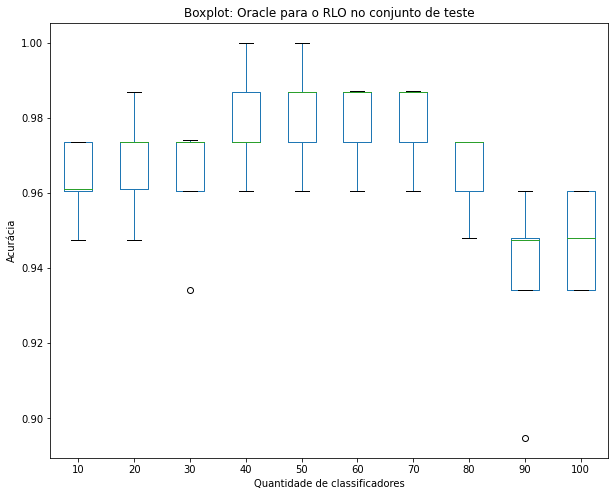

In [22]:
rlo_oracle_df.boxplot(figsize=(10,8), grid=False)
plt.title('Boxplot: Oracle para o RLO no conjunto de teste')
plt.xlabel('Quantidade de classificadores')
plt.ylabel('Acurácia')
plt.show();

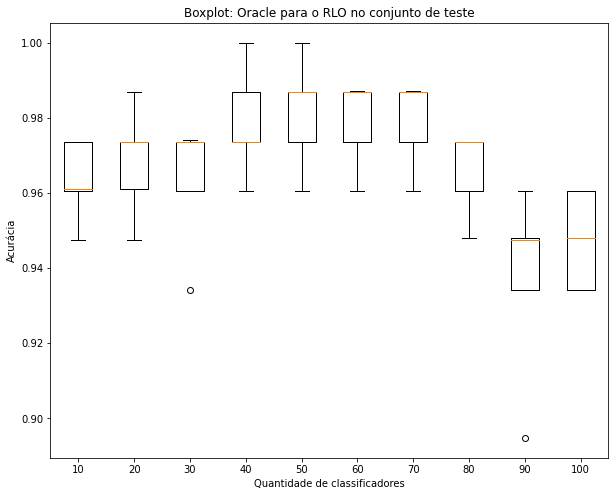

In [23]:
plt.figure(figsize=(10,8))
plt.boxplot(rlo_oracles.values(), labels=rlo_oracles.keys())
plt.title('Boxplot: Oracle para o RLO no conjunto de teste')
plt.xlabel('Quantidade de classificadores')
plt.ylabel('Acurácia')
plt.show();

### Implementar funções para os demais modelos

In [24]:
# função para criar os classificadores com o Perceptron como classificador base
def L_modelos(classificador, random_subspace=False):
    if random_subspace:
        max_features = 0.5 # 50% de features
        modelos = dict()
        n_classificadores = np.arange(10, 110, 10)
        for n in n_classificadores:
            modelos[str(n)] = classificador(CalibratedClassifierCV(Perceptron(max_iter=10)), 
                                            n_estimators = n, 
                                            max_features=max_features)
        
    else:
        max_features = 1.0
        
        modelos = dict()
        n_classificadores = np.arange(10, 110, 10)
        for n in n_classificadores:
            modelos[str(n)] = classificador(CalibratedClassifierCV(Perceptron(max_iter=10)), 
                                            n_estimators = n)
        
    return modelos

# função para realizar a validação cruzada dos classificadores 
def avalia_L_modelos(L_classificadores, X, y, kfolds):
    
    scores_L = dict.fromkeys(L_classificadores)
    
    for classificador in L_classificadores:
        print('Qtd. classificadores: ', classificador)
        scores = dict.fromkeys(kfolds.keys())
        for fold, (train_idx, test_idx) in kfolds.items():
            L_classificadores[classificador].fit(X[train_idx], y[train_idx])
            pred = L_classificadores[classificador].predict(X[test_idx])
            scores[fold] = {'acuracia': accuracy_score(y[test_idx], pred),
                           'modelo': L_classificadores[classificador]}
            
        scores_L[classificador] = scores
    
    return scores_L
            
            
    
    
    
#     # criando dicionário para receber os scores
#     scores = dict.fromkeys(kfolds.keys())
    
#     # loop para criar os folds
#     for fold, (id_train, id_test) in kfolds.items():
#         print(fold)
#         X_train, X_test = X[id_train], X[id_test]
#         y_train, y_test = y[id_train], y[id_test]
        
#         # criar dicionário para receber os scores dos folds
#         scores_L = dict.fromkeys(L_classificadores)
#         # loop para realizar treinamento e classificação
#         for classificador in L_classificadores:
#             print('Qtd. classificadores: ', classificador)
#             L_classificadores[classificador].fit(X_train, y_train)
#             pred = L_classificadores[classificador].predict(X_test)
#             scores_L[classificador] = {'accuracy': accuracy_score(y_test, pred), 
#                                        'modelo': L_classificadores[classificador]}
        
#         # armazenar score para os L_classificadores
#         scores[fold] = scores_L
        
#     return scores
    

In [ ]:
# criando os L classificadores
modelos_L = L_modelos(BaggingClassifier)

# avaliando por validação cruzada
bagging_classifier_cv = avalia_L_modelos(modelos_L, X_train, y_train, kfolds)

In [ ]:
print('média:         ',np.mean([bagging_classifier_cv['10'][f'fold{i}']['acuracia'] for i in range(1, 6)]))
print('desvio padrão: ', np.std([bagging_classifier_cv['10'][f'fold{i}']['acuracia'] for i in range(1, 6)], ddof=1))

In [ ]:
# mostrando a accuracy para cada fold para todos os n classificadores
print('10: ', [bagging_classifier_cv['10'][f'fold{i}']['acuracia'] for i in range(1, 6)])
print('20: ',[bagging_classifier_cv['20'][f'fold{i}']['acuracia'] for i in range(1, 6)])

In [ ]:
# Adaboost
# criando os L classificadores
modelos_L_adaboost = L_modelos(AdaBoostClassifier)

adaboost_classifier_cv = avalia_L_modelos(modelos_L_adaboost, X_train, y_train, kfolds)

In [ ]:
print('média:         ',np.mean([adaboost_classifier_cv['10'][f'fold{i}']['acuracia'] for i in range(1, 6)]))
print('desvio padrão: ', np.std([adaboost_classifier_cv['10'][f'fold{i}']['acuracia'] for i in range(1, 6)], ddof=1))

In [ ]:
# mostrando a accuracy para cada fold para todos os n classificadores
print('10: ', [adaboost_classifier_cv['10'][f'fold{i}']['acuracia'] for i in range(1, 6)])
print('20: ',[adaboost_classifier_cv['20'][f'fold{i}']['acuracia'] for i in range(1, 6)])


In [ ]:
## random subspace
# criando os L classificadores
modelos_L_random_subspace = L_modelos(BaggingClassifier, True)

random_subspace_classifier_cv = avalia_L_modelos(modelos_L_random_subspace, X_train, y_train, kfolds)

In [ ]:
print('média:         ',np.mean([random_subspace_classifier_cv['10'][f'fold{i}']['acuracia'] for i in range(1, 6)]))
print('desvio padrão: ', np.std([random_subspace_classifier_cv['10'][f'fold{i}']['acuracia'] for i in range(1, 6)], ddof=1))

In [ ]:
# mostrando a accuracy para cada fold para todos os n classificadores
print('10: ', [random_subspace_classifier_cv['10'][f'fold{i}']['acuracia'] for i in range(1, 6)])
print('30: ',[random_subspace_classifier_cv['30'][f'fold{i}']['acuracia'] for i in range(1, 6)])


In [ ]:
## Oracle
## Bagging
def avalia_oracle(classificador_cv, X, y, kfolds):
    classificador_oracles = dict.fromkeys(classificador_cv.keys())
    for n in classificador_oracles:
        print('Qtd. classificadores: ', n)
        oracles = []
        for fold, (_, test_id) in kfolds.items():
            oracle_i = oracle.Oracle(classificador_cv[n][fold]['modelo'])
            oracle_score = oracle_i.score(X[test_id], y[test_id])
            oracles.append(oracle_score)
        classificador_oracles[n] = oracles
    return classificador_oracles
    
# bag_oracles = dict.fromkeys(bagging_classifier_cv.keys())
# for n in n_classificadores:
#     print('Qtd. classificadores: ', n)
#     oracles = [] 
#     for fold, (_, test_id) in kfolds.items():
#         oracle_i = oracle.Oracle(bagging_classifier_cv[str(n)][fold]['modelo'])
# #         oracle_pred = oracle_i.predict(X_train[test_id], y_train[test_id])
#         oracle_score = oracle_i.score(X_train[test_id], y_train[test_id])
# #         oracles_fold[fold] = {'pred':oracle_pred, 'score': oracle_score}
#         oracles.append(oracle_score)
#     bag_oracles[str(n)] = oracles

In [ ]:
bag_oracles = avalia_oracle(bagging_classifier_cv, X_train, y_train, kfolds)
bag_oracles_df = pd.DataFrame(bag_oracles)

adaboost_oracles = avalia_oracle(adaboost_classifier_cv, X_train, y_train, kfolds)
adaboost_oracles_df = pd.DataFrame(adaboost_oracles)

In [ ]:
bag_oracles_df

In [ ]:
adaboost_oracles_df

In [ ]:
plt.figure(figsize=(10,8))
plt.boxplot(bag_oracles.values(), labels=bag_oracles.keys())
plt.title('Boxplot: Oracle para o Bagging no conjunto de teste')
plt.xlabel('Quantidade de classificadores')
plt.ylabel('Acurácia')
plt.show();

In [ ]:
plt.figure(figsize=(10,8))
plt.boxplot(adaboost_oracles.values(), labels=adaboost_oracles.keys())
plt.title('Boxplot: Oracle para o Adaboost no conjunto de teste')
plt.xlabel('Quantidade de classificadores')
plt.ylabel('Acurácia')
plt.show();

In [ ]:
# oraculo = oracle.Oracle(random_subspace_classifier_cv['fold1']['20']['modelo'])

In [ ]:
# _, test_idx = kfolds['fold1']
# X2, y2 = X_train[test_idx], y_train[test_idx]

# oraculo = oracle.Oracle(bagging_classifier_cv['fold1']['10']['modelo'])
# oraculo.predict(X2, y2)
# oraculo.score(X2, y2)


## 2)
Use as mesma bases de dados e os mesmos folds da questão anterior e, para cada base: 
- use o **SGH** para gerar o pool de classificadores no conjunto de treinamento; 

- calcule o Oracle do pool no conjunto de teste; 

- verifique quantas instâncias por classe foram incorretamente classificadas; 

- verifique quantos hiperplanos por classe foram gerados. 

Analise os resultados coletados. 

In [ ]:
import sgh

## TODO 

### Código para gerar os modelos SGH para as cinco bases de dados. Calcular o ORACLE 